# This is note book to test our data model.

**The table reviews only contains data in state AZ, because other states have too little data.**

In [1]:
#! /home/rick/anaconda3/envs/de_capstone/bin/python

import os
import datetime
import configparser

os.environ['SPARK_HOME'] = '/home/rick/spark-3.0.0-preview2-bin-hadoop2.7'
os.environ['PYSPARK_PYTHON'] = '/home/rick/anaconda3/envs/udacity_de/bin/python'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/rick/anaconda3/envs/udacity_de/bin/ipython'

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window

import pandas as pd
import numpy as np
spark = SparkSession.builder\
                     .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
                     .getOrCreate()
project_dir = '/mnt/data-ubuntu/Projects/data_engineering_projects/project_6_capstone'

In [18]:
df_review = spark.read \
    .format('parquet') \
    .option('basePath', project_dir + '/data/output_test/reviews') \
    .load(project_dir + '/data/output_test/reviews/year=2018')
df_business = spark.read \
    .format('parquet') \
    .option('basePath', project_dir + '/data/output_test/businesses') \
    .load(project_dir + '/data/output_test/businesses/state=AZ')
df_business_category_link = spark.read \
    .format('parquet') \
    .option('basePath', project_dir + '/data/output_test/business_category_link') \
    .load(project_dir + '/data/output_test/business_category_link/state=AZ')
df_category = spark.read.parquet(project_dir + '/data/output_test/category')
df_users = spark.read.parquet(project_dir + '/data/output_test/users')
df_weather = spark.read.parquet(project_dir + '/data/output_test/weather')

In [19]:
df_review.createOrReplaceTempView('reviews')
df_business.createOrReplaceTempView('businesses')
df_business_category_link.createOrReplaceTempView('business_category_link')
df_category.createOrReplaceTempView('category')
df_users.createOrReplaceTempView('users')
df_weather.createOrReplaceTempView('weather')

## How many reveiws are there in year 2018?

In [21]:
sql = '''

SELECT COUNT(*) AS NUM_REVIEWS
FROM REVIEWS

'''
spark.sql(sql).show()

+-----------+
|NUM_REVIEWS|
+-----------+
|     424433|
+-----------+



## Which business has the highest review stars on average in 2018?

In [25]:
sql = '''

SELECT 
    B.NAME,
    B.ADDRESS,
    B.CITY,
    B.POSTAL_CODE,
    AVG(R.STARS) AS AVG_STARS
FROM BUSINESSES B
    LEFT JOIN REVIEWS R ON R.BUSINESS_ID = B.BUSINESS_ID
GROUP BY B.NAME,B.ADDRESS,B.CITY,B.POSTAL_CODE
ORDER BY AVG(R.STARS) DESC
LIMIT 1
'''
spark.sql(sql).show()

+--------------------+------------------+-----+-----------+---------+
|                NAME|           ADDRESS| CITY|POSTAL_CODE|AVG_STARS|
+--------------------+------------------+-----+-----------+---------+
|Carneceria Don Fi...|1533 E Apache Blvd|Tempe|      85281|      5.0|
+--------------------+------------------+-----+-----------+---------+



## Which business has the most number of reviews in 2018?

In [26]:
sql = '''

SELECT 
    B.NAME,
    B.ADDRESS,
    B.CITY,
    B.POSTAL_CODE,
    COUNT(*) AS NUM_REVIEWS
FROM BUSINESSES B
    LEFT JOIN REVIEWS R ON R.BUSINESS_ID = B.BUSINESS_ID
GROUP BY B.NAME,B.ADDRESS,B.CITY,B.POSTAL_CODE
ORDER BY COUNT(*) DESC
LIMIT 1

'''
spark.sql(sql).show()

+--------------------+--------------------+-------+-----------+-----------+
|                NAME|             ADDRESS|   CITY|POSTAL_CODE|NUM_REVIEWS|
+--------------------+--------------------+-------+-----------+-----------+
|The Sicilian Butcher|15530 N Tatum Blv...|Phoenix|      85032|        893|
+--------------------+--------------------+-------+-----------+-----------+



## Which subcategory in the category Restaurants has the highest review stars on average in 2018?

In [43]:
# TOP 10
sql = '''
SELECT 
    C.SUBCATEGORIES,
    ROUND(AVG(R.STARS),2) AS AVG_STARS,
    COUNT(*) AS NUM_REVIEWS
FROM BUSINESSES B
    LEFT JOIN REVIEWS R ON B.BUSINESS_ID = R.BUSINESS_ID
    LEFT JOIN BUSINESS_CATEGORY_LINK BC ON BC.BUSINESS_ID = B.BUSINESS_ID
    LEFT JOIN CATEGORY C ON C.INDEX = BC.INDEX
WHERE CATEGORY = 'Restaurants'
GROUP BY C.SUBCATEGORIES
ORDER BY ROUND(AVG(R.STARS),2) DESC
LIMIT 10
'''
spark.sql(sql).show()

+------------------+---------+-----------+
|     SUBCATEGORIES|AVG_STARS|NUM_REVIEWS|
+------------------+---------+-----------+
|           Catalan|      5.0|          3|
|         Ukrainian|     4.78|        181|
|Rotisserie Chicken|     4.77|         22|
|             Uzbek|     4.76|         42|
|           Russian|      4.7|        154|
|              Pita|      4.6|         16|
|           Arabian|     4.54|        364|
|             Cuban|     4.53|        446|
|         Ethiopian|     4.45|        158|
|            Polish|     4.43|        381|
+------------------+---------+-----------+



In [44]:
# LAST 10
sql = '''
SELECT 
    C.SUBCATEGORIES,
    ROUND(AVG(R.STARS),2) AS AVG_STARS,
    COUNT(*) AS NUM_REVIEWS
FROM BUSINESSES B
    LEFT JOIN REVIEWS R ON B.BUSINESS_ID = R.BUSINESS_ID
    LEFT JOIN BUSINESS_CATEGORY_LINK BC ON BC.BUSINESS_ID = B.BUSINESS_ID
    LEFT JOIN CATEGORY C ON C.INDEX = BC.INDEX
WHERE CATEGORY = 'Restaurants'
GROUP BY C.SUBCATEGORIES
ORDER BY ROUND(AVG(R.STARS),2)
LIMIT 10
'''
spark.sql(sql).show()

+------------------+---------+-----------+
|     SUBCATEGORIES|AVG_STARS|NUM_REVIEWS|
+------------------+---------+-----------+
|Himalayan/Nepalese|     null|          1|
|           Burmese|     null|          1|
|          Pub Food|     null|          1|
|         Argentine|     2.15|         23|
|       Beer Garden|     2.24|         63|
|           Laotian|     2.85|         27|
|         Fast Food|     2.87|      18423|
|      Chicken Shop|     3.22|       1708|
|        Food Court|     3.27|        371|
|        Polynesian|     3.28|         33|
+------------------+---------+-----------+



If I'm going to open a business, I will not open a fast food restaurant...

## When do the users like to leave a reveiw(Which hour in a day) in 2018?

In [47]:
sql = '''

SELECT 
    HOUR,
    COUNT(*) AS NUM_REVIEWS
FROM REVIEWS
GROUP BY HOUR
ORDER BY HOUR
'''
spark.sql(sql).show()

+----+-----------+
|HOUR|NUM_REVIEWS|
+----+-----------+
|   0|      27187|
|   1|      28582|
|   2|      29295|
|   3|      28235|
|   4|      22763|
|   5|      15992|
|   6|       9507|
|   7|       5543|
|   8|       3086|
|   9|       1911|
|  10|       1410|
|  11|       1597|
|  12|       2758|
|  13|       5663|
|  14|      10323|
|  15|      15328|
|  16|      19913|
|  17|      23467|
|  18|      26305|
|  19|      30198|
+----+-----------+
only showing top 20 rows



## Which user wrote the most number of reviews in 2018

In [50]:
sql = '''

SELECT
    U.USER_ID,
    NAME,
    COUNT(*) AS NUM_REVIEWS
FROM USERS U
    LEFT JOIN REVIEWS R ON R.USER_ID = U.USER_ID
GROUP BY U.USER_ID,NAME
ORDER BY COUNT(*) DESC
LIMIT 1

'''
spark.sql(sql).show()

+--------------------+-------+-----------+
|             USER_ID|   NAME|NUM_REVIEWS|
+--------------------+-------+-----------+
|7C4B2Skmh4X9f8xJD...|Dolores|        325|
+--------------------+-------+-----------+



The user Dolores wrote 325 reviews in 2018!

## Which business has the most number of patrons(users who left more than two reviews for the same business)?

In [62]:
sql = '''

SELECT 
    BUSINESS_ID,
    NAME,
    COUNT(*) AS NUM_PATRONS
FROM (
        SELECT
            B.BUSINESS_ID,
            B.NAME,
            R.USER_ID,
            COUNT(*) AS NUM_REVIEWS
        FROM BUSINESSES B
            INNER JOIN REVIEWS R ON R.BUSINESS_ID = B.BUSINESS_ID
        GROUP BY B.BUSINESS_ID, B.NAME, R.USER_ID
        HAVING COUNT(*) > 1
        ) T
GROUP BY BUSINESS_ID, NAME
ORDER BY COUNT(*) DESC
LIMIT 1

'''
spark.sql(sql).show()

+--------------------+--------------------+-----------+
|         BUSINESS_ID|                NAME|NUM_PATRONS|
+--------------------+--------------------+-----------+
|EDcZRvERC22Cvw1yi...|The Sicilian Butcher|         21|
+--------------------+--------------------+-----------+



## What's the relationship between num_friends and average_stars in table users?

In [66]:
import pandas 
import matplotlib.pyplot as plt

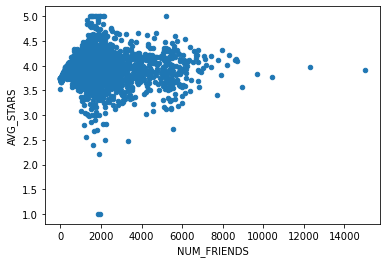

In [75]:

sql = '''

SELECT
    NUM_FRIENDS,
    AVG(AVERAGE_STARS) AS AVG_STARS
FROM USERS U
GROUP BY NUM_FRIENDS
ORDER BY NUM_FRIENDS

'''
spark.sql(sql) \
    .toPandas() \
    .sort_values('NUM_FRIENDS') \
    .plot(kind = 'scatter', x = 'NUM_FRIENDS', y = 'AVG_STARS' )
plt.show()

There are some outliers, but we don't see obvious trend between two variables.

## What's the relationship between feels_like in table weather and average stars for restaurants?

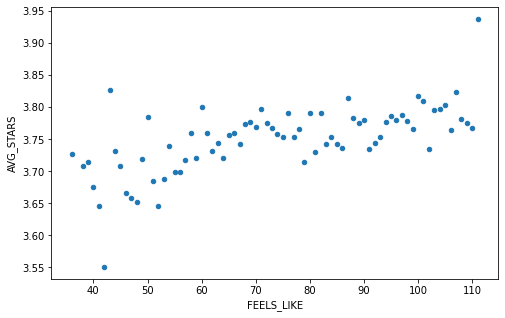

In [94]:
sql = '''

SELECT
    W.FEELS_LIKE,
    AVG(R.STARS) AS AVG_STARS
FROM REVIEWS R
    INNER JOIN WEATHER W ON W.ID = R.WEATHER_ID
WHERE W.FEELS_LIKE IS NOT NULL
GROUP BY W.FEELS_LIKE
HAVING COUNT(*)>100
ORDER BY W.FEELS_LIKE

'''
fig, ax = plt.subplots(figsize=(8,5))
df = spark.sql(sql) \
    .toPandas() \
    .sort_values('FEELS_LIKE') \
    .plot(kind = 'scatter', x = 'FEELS_LIKE', y = 'AVG_STARS', ax = ax)
plt.show()

There is a trend that people tend to wrote a review with higher stars when the "feels_like" temperature is higher.